In [1]:
def trace(x,y):
    return 1 if x==y else 0

class EligibilityTrace:

    def __init__(self, kind = None, et_lambda = 0.5, gamma = 1):
        self.et_dict = {}
        self.et_lambda = et_lambda
        self.gamma = gamma

    def __call__(self, *x):
        return self.et_dict.get(x, 0)

    def update(self, *x):
        self.et_dict = {y: self.gamma * self.et_lambda * self.et_dict[y] + trace(y, x) for y in self.et_dict}
        if x not in self.et_dict: self.et_dict[tuple(x)] = 1
            
    def get_relevant_states(self):
        return [x for x in self.et_dict]

# Lambda Sarsa

In [2]:
import sys 
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt

from grid_world.action import Action
from grid_world.grid_world import GridWorld
# from grid_world.agents.sarsa_agent import SarsaAgent
from grid_world.visualization.format_objects import get_policy_rec_str, get_policy_eval_str, get_world_str
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action

np.random.seed(21)

In [3]:
gworld = GridWorld(
    grid_shape=(4,5), 
    terminal_states_coordinates=((0,4),),
    walls_coordinates=((0,1), (1,1), (2,3)),
    traps_coordinates=((1,3),),
)
print(get_world_str(gworld))

3               

2          █    

1    █     ☠    

0 ⚐  █        ✘ 

  0  1  2  3  4 


In [4]:
from typing import Final, Collection

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.state import State
from grid_world.type_aliases import Policy, RewardFunction, Q
from grid_world.utils.policy import (
    get_random_policy,
    sample_action,
    get_e_greedy_policy,
)
from grid_world.utils.returns import returns_from_reward


class SarsaLambdaAgent:
    def __init__(
        self,
        world: GridWorld,
        reward_function: RewardFunction,
        actions: Collection[Action] = None,
        policy: Policy = None,
        gamma: float = 1,
        alpha: float = 0.1,
        epsilon: float = 0.1,
        et_lambda: float = 0.5,
        q_0: Q = None,
    ):
        """
        Agent implementing a solution based on estimating the value of state-action pairs. It updates values after
        every action, by observing results, selecting a next action and bootstrapping values from this information.

        :world: the world this agent will explore
        :reward_function: the reward function we are trying to maximize
        :actions: actions available to the agent
        :policy: initial policy for the agent
        :gamma: the gamma discount value to be used when calculating episode returns
        :alpha: learning rate
        :epsilon: exploration rate to be considered when building policies
        :q_0: initial estimates of state-action values, will be considered as a constant 0 if not provided

        """
        self.world: Final = world
        self.reward_function: Final = reward_function
        self.actions: Final = actions if actions is not None else tuple(Action)
        self.policy = Policy if policy is not None else get_random_policy(self.actions)
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.et_lambda = et_lambda
        self.q: Q = (
            q_0
            if q_0 is not None
            else {(s, a): 0 for s in self.world.states for a in self.actions}
        )
        self.visited_states: set[State] = set()

    def train(
        self,
        episodes: int = 100,
    ) -> tuple[list[int], list[float]]:
        episode_lengths = []
        episode_total_returns = []
        for _ in range(episodes):
            episode_actions, episode_states, episode_rewards = self.run_episode()
            episode_returns = returns_from_reward(episode_rewards, self.gamma)
            episode_lengths.append(len(episode_actions))
            episode_total_returns.append(episode_returns[0])

        return episode_lengths, episode_total_returns

    def run_episode(self, initial_state: State = None) -> [bool, int]:
        eligibility_trace = EligibilityTrace(et_lambda = self.et_lambda, gamma = self.gamma)
        state = initial_state if initial_state is not None else self.world.initial_state
        
        episode_states = [state]
        episode_actions = []
        episode_rewards = []

        # run through the world while updating q and the policy as we go
        action = sample_action(self.policy, state, self.actions)
        effect = 0
        while effect != 1:
            eligibility_trace.update(state, action)
            new_state, effect = self.world.take_action(state, action)
            next_action = sample_action(self.policy, new_state, self.actions)
            reward = self.reward_function(effect)
            self.visited_states.add(new_state)

            # learn from what happened
            delta = reward + self.gamma * self.q[new_state, next_action] - self.q[state, action]
            update_dict = {
                sap: self.q[sap] + self.alpha * delta * eligibility_trace(*sap)
                for sap in eligibility_trace.get_relevant_states()
            }
            self.q.update(update_dict)

            # improve from what was learned
            self.policy = get_e_greedy_policy(
                self.q, self.visited_states, self.actions, self.epsilon
            )

            state = new_state
            episode_actions.append(action)
            episode_states.append(state)
            episode_rewards.append(reward)
            action = next_action

        return episode_actions, episode_states, episode_rewards


In [5]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -10
    else:
        return -1

In [6]:
slagent = SarsaLambdaAgent(
    world = gworld,
    reward_function = reward,
    actions = [Action.up, Action.down, Action.left, Action.right],
    gamma = 1,
    alpha = 0.1,
    epsilon = 0.1
)

episode_lengths, episode_returns = slagent.train(episodes = 200)
pi_r = get_policy_rec(slagent.policy, gworld, slagent.actions)
print(get_policy_rec_str(pi_r, gworld))

 ↓  ↓  ↓  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




In [13]:
sarsa_returns = []
sarsa_lengths = []
training_rounds = 50

for _ in range(training_rounds):

    sarsa_agent = SarsaLambdaAgent(
        world = gworld,
        reward_function = reward,
        actions = [Action.up, Action.down, Action.left, Action.right],
        gamma = 1,
        alpha = 0.1,
        epsilon = 0.1
    )

    sarsa_episode_lengths, sarsa_episode_returns = sarsa_agent.train(episodes = 100)
    sarsa_returns.append(sarsa_episode_returns)
    sarsa_lengths.append(sarsa_episode_lengths)
    
sarsa_pi_r = get_policy_rec(sarsa_agent.policy, gworld, sarsa_agent.actions)
sarsa_average_returns = np.mean(np.array(sarsa_returns), axis=0)
sarsa_average_lengths = np.mean(np.array(sarsa_lengths), axis=0)
sarsa_std_returns = np.std(np.array(sarsa_returns), axis=0)
print(get_policy_rec_str(sarsa_pi_r, gworld))

 →  →  →  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




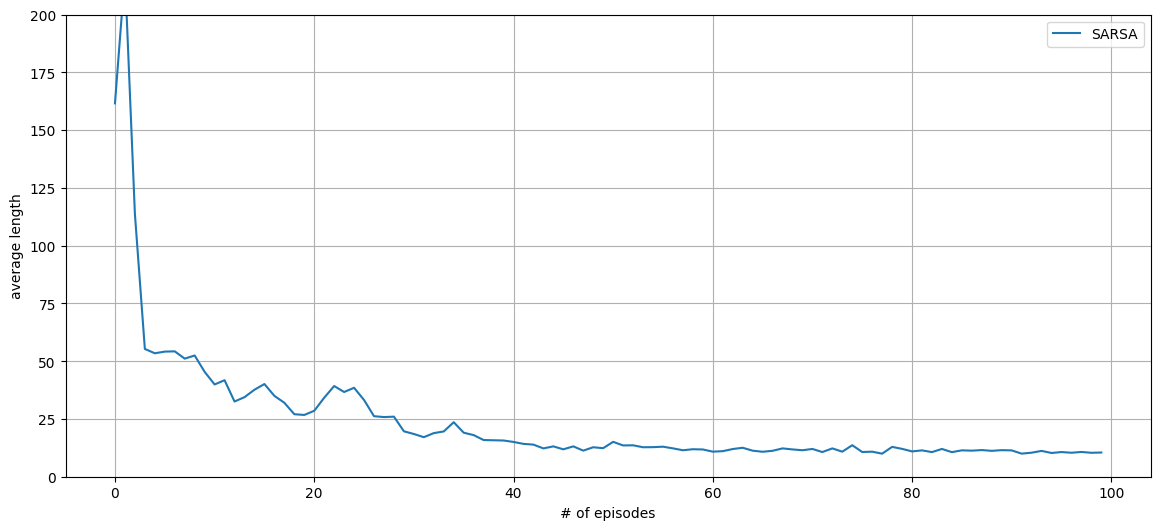

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(sarsa_average_lengths, label = "SARSA")

ax.set(
    xlabel='# of episodes', 
    ylabel='average length', 
    ylim=[0, 200]
)
ax.grid()
ax.legend(loc="upper right")

plt.show()

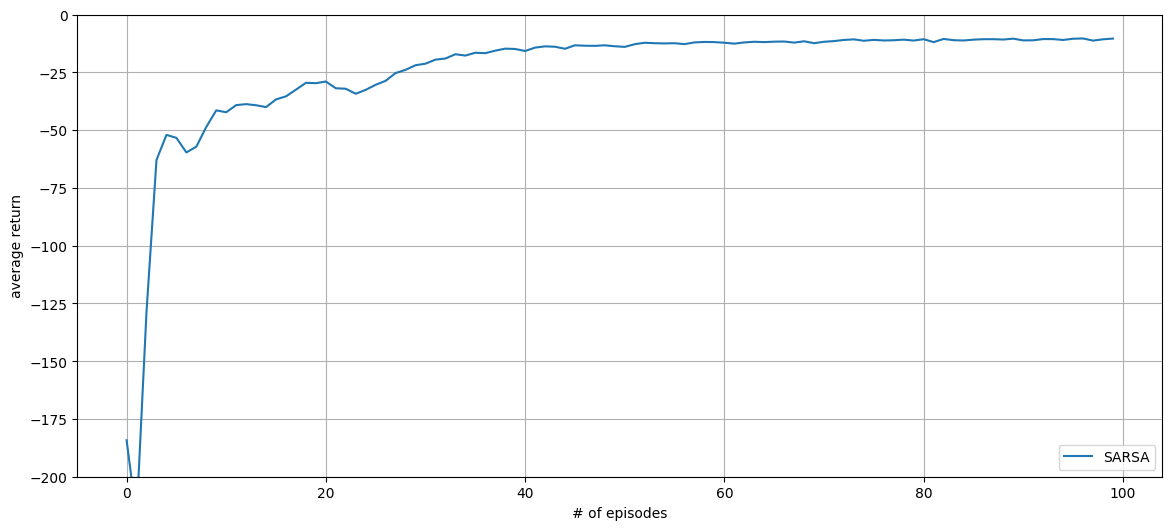

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(sarsa_average_returns, label = "SARSA")

ax.set(
    xlabel='# of episodes', 
    ylabel='average return', 
    ylim=[-200, 0]
)
ax.grid()
ax.legend(loc="lower right")

plt.show()

In [10]:
print(f"""
Average accumulated return

SARSA: {np.mean(sarsa_average_returns):.2f}

Average accumulated return of last 10 episodes

SARSA: {np.mean(sarsa_average_returns[-10:]):.2f}
""")


Average accumulated return

SARSA: -24.39

Average accumulated return of last 10 episodes

SARSA: -10.70

